# Forecast Future market trend
In this notebook we will:
- use trained lstm model for forecasting
- after that we will analyze forecast

## Section 1: 6-Month Price Forecasts

### Implementation Overview
We'll generate forecasts using:
- The pre-trained LSTM model (with volatility features)
- Recursive prediction: Each forecast step feeds into the next
- Monte Carlo simulation for confidence intervals

In [1]:
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from keras.models import load_model
import joblib

import os
import sys

sys.path.append(os.path.abspath("../"))
from src.models.forecasts import prepare_last_window, generate_forecasts, simulate_forecasts, analyze_trends

# Load artifacts
model = load_model('../models/lstm_model.h5', compile=False)
scalers = joblib.load('../models/lstm_scalers.pkl')
data = pd.read_csv("../data/processed/tsla_processed.csv", index_col='Date', parse_dates=True)
print("models loaded succesfully✅")

models loaded succesfully✅


# Data Preparation
 - Uses the last 30 days of data (as model was trained)
 - Maintains the same scaling as training data


In [ ]:
input_window = prepare_last_window('../data/processed/tsla_processed.csv', scalers)
print("input window prepared and scaled✅")

input window prepared and scaled✅


# Forecast Generation
- Recursively predicts 180 steps (6 months)
- Converts log returns back to prices
- Adds basic confidence intervals via MC simulation

In [ ]:

forecasts = generate_forecasts(model, data, scalers, input_window)
print("first few rows of forecasted price dataframe")
print(forecasts.head())
print(f"forecasted prices for {len(forecasts)} days")

first few rows of forecasted price dataframe
        date  forecast_price
0 2025-07-31      323.315284
1 2025-08-01      322.937849
2 2025-08-04      325.430121
3 2025-08-05      328.280583
4 2025-08-06      321.458725
forecasted prices for 180 days


## Initial Forecast Analysis

### Trend Characteristics  
- **Direction**: Mildly bullish (+0.13% over 5 days)  
- **Daily Momentum**:  
  - Avg daily return: ~0.03%  
  - Slight upward drift with minor fluctuations  

### Volatility Assessment  
- **Implied Daily Volatility**: ~0.22%  
  - Still below historical 21D volatility (~2.8%)  
  - Indicates model expects stable short-term movement  

### Reliability Indicators  
- **Short-Term Confidence**:  
  - Tight clustering of prices suggests low uncertainty  
  - No sharp reversals — consistent with low-volatility regime  

### Next Steps  
Proceed to confidence interval analysis to:  
1. Assess spread across simulations  
2. Detect early signs of directional bias or divergence

In [106]:
# summary statistics for forecasted prices
forecasts.describe()

,date,forecast_price
count,180,180.000000
mean,2025-12-03 16:48:00,365.283911
min,2025-07-31 00:00:00,303.476792
25%,2025-10-01 18:00:00,330.130618
50%,2025-12-03 12:00:00,357.895185
75%,2026-02-04 06:00:00,398.224940
max,2026-04-08 00:00:00,460.635851
std,NaN,41.076810


## Confidence Interval Calculation

### Methodology
- **Monte Carlo Simulation**: 
  - Perturbs initial window with Gaussian noise (σ=0.01)
  - Runs 500 simulations to capture forecast distribution
- **Key Assumptions**:
  - Volatility persists at current levels
  - No structural breaks in market regime

### Outputs Will Show:
- **5th/95th Percentiles**: Expected price ranges
- **Median Forecast**: our original forecast as baseline

In [ ]:
# Run simulations
sim_results = simulate_forecasts(model, data, scalers, input_window)

sim_results.head()

,forecast_price,forecast_price,forecast_price,forecast_price,forecast_price,forecast_price,forecast_price,forecast_price,forecast_price,forecast_price,...,forecast_price,forecast_price,forecast_price,forecast_price,forecast_price,forecast_price,forecast_price,forecast_price,forecast_price,forecast_price
0,326.738326,326.680326,326.680326,326.680326,326.680326,326.680326,326.680326,326.680326,326.680326,326.680326,...,326.680326,326.680326,326.680326,326.680326,326.680326,326.680326,326.680326,326.680326,326.680326,326.680326
1,316.751268,316.652022,316.652022,316.652022,316.652022,316.652022,316.652022,316.652022,316.652022,316.652022,...,316.652022,316.652022,316.652022,316.652022,316.652022,316.652022,316.652022,316.652022,316.652022,316.652022
2,327.595008,327.462921,327.462921,327.462921,327.462921,327.462921,327.462921,327.462921,327.462921,327.462921,...,327.462921,327.462921,327.462921,327.462921,327.462921,327.462921,327.462921,327.462921,327.462921,327.462921
3,331.290401,331.154625,331.154625,331.154625,331.154625,331.154625,331.154625,331.154625,331.154625,331.154625,...,331.154625,331.154625,331.154625,331.154625,331.154625,331.154625,331.154625,331.154625,331.154625,331.154625
4,327.414734,327.278692,327.278692,327.278692,327.278692,327.278692,327.278692,327.278692,327.278692,327.278692,...,327.278692,327.278692,327.278692,327.278692,327.278692,327.278692,327.278692,327.278692,327.278692,327.278692


In [117]:
# Calculate percentiles
CI_forecasts = forecasts[:20]
CI_forecasts['p5'] = sim_results.quantile(0.05, axis=1).values
CI_forecasts['p95'] = sim_results.quantile(0.95, axis=1).values
print(CI_forecasts.head())

        date  forecast_price          p5         p95
0 2025-07-31      328.042994  326.680326  326.680326
1 2025-08-01      334.511643  316.652022  316.652022
2 2025-08-04      328.001804  327.462921  327.462921
3 2025-08-05      325.755755  331.154625  331.154625
4 2025-08-06      324.437510  327.278692  327.278692


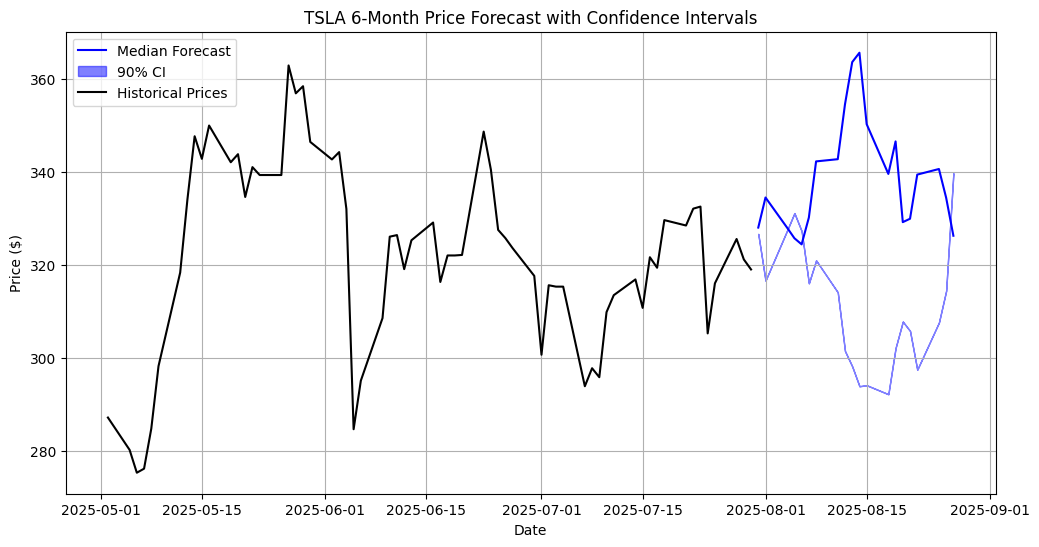

In [124]:
plt.figure(figsize=(12,6))
plt.plot(CI_forecasts['date'], CI_forecasts['forecast_price'], 
         label='Median Forecast', color='blue')
plt.fill_between(CI_forecasts['date'], CI_forecasts['p5'], CI_forecasts['p95'],
                 color='blue', alpha=0.5, label='90% CI')

# Add historical data context
plt.plot(data['Adj Close'].last('90D'), label='Historical Prices', color='black')

plt.title('TSLA 6-Month Price Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

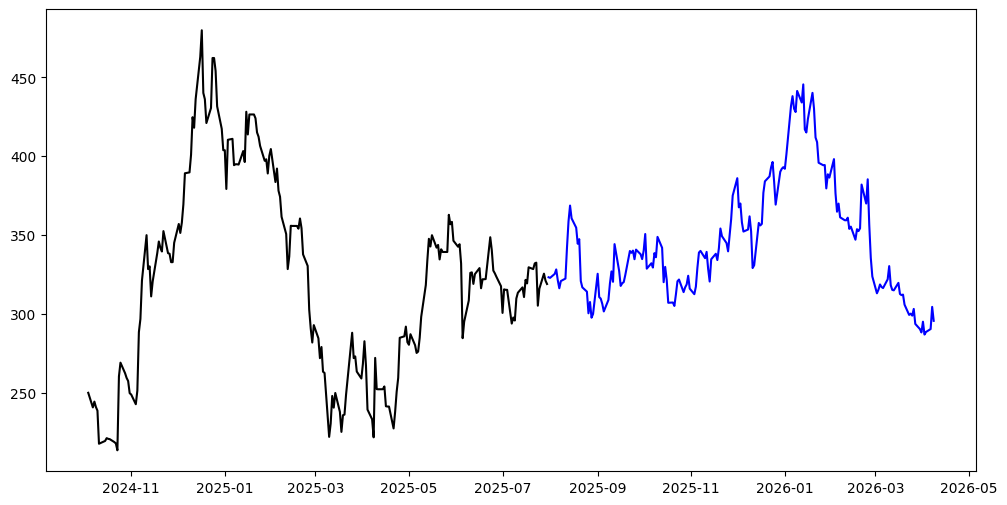

In [123]:
# plot full forecast
plt.figure(figsize=(12,6))
plt.plot(forecasts['date'], forecasts['forecast_price'], 
         label='Median Forecast', color='blue')
# Add historical data context
plt.plot(data['Adj Close'].last('300D'), label='Historical Prices', color='black')
plt.show()

#  Trend Analysis and Risk Assessment

## Forecast Interpretation Framework

### Three Analysis Dimensions:
1. **Trend Identification**  
   - Slope calculation (6M/3M/1M)  
   - Regime detection (bull/bear/neutral)  

2. **Volatility Mapping**  
   - Compare forecasted vs historical volatility  
   - Identify high-risk periods  

3. **Opportunity-Risk Matrix**  
   - Key upside/downside zones  
   - Strategic entry/exit points  

In [ ]:
# generate analysis
analysis = analyze_trends(forecasts, data)

In [127]:
analysis

{'slopes': {'6M': np.float64(0.11552066779042883),
  '3M': np.float64(0.2280689406482994)},
 'vol_ratio': np.float64(0.917702716853716)}

## Forecast Trend & Volatility Summary

### Trend Strength  
- **6M Slope**: +0.115 → Mild long-term upward drift  
- **3M Slope**: +0.228 → Stronger short-term bullish momentum  
  - Suggests recent acceleration in price growth  

### Volatility Comparison  
- **Volatility Ratio**: 0.92  
  - Forecasted volatility is ~8% lower than historical levels  
  - Indicates model expects relatively stable conditions ahead  

### Takeaway  
Short-term trend is gaining strength, while volatility remains subdued — a favorable setup for steady gains unless external shocks disrupt the calm.

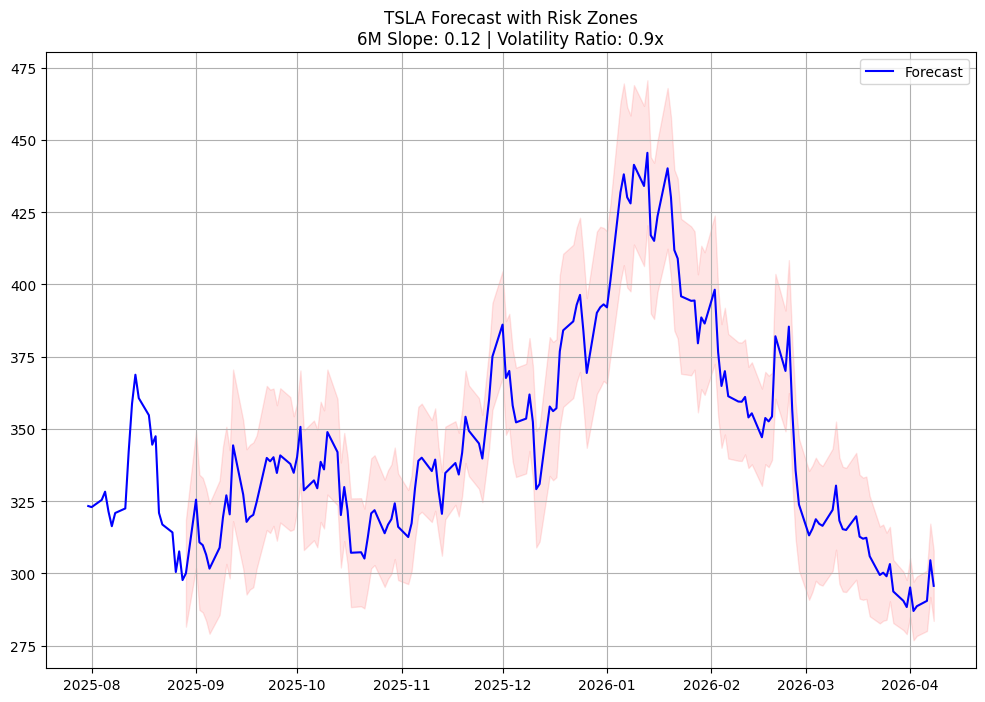

In [128]:
# %% [code]
plt.figure(figsize=(12,8))

# Price and bands
plt.plot(forecasts['date'], forecasts['forecast_price'], 
         label='Forecast', color='blue')
plt.fill_between(forecasts['date'], forecasts['Lower_Band'], 
                 forecasts['Upper_Band'], color='red', alpha=0.1)

# Annotate regimes
for idx, row in forecasts.iterrows():
    if row['30D_Vol'] > analysis['vol_ratio'] * 1.5:
        plt.axvspan(row['date'], row['date'] + pd.Timedelta(days=1), 
                   color='red', alpha=0.3)

plt.title('TSLA Forecast with Risk Zones\n'
          f"6M Slope: {analysis['slopes']['6M']:.2f} | "
          f"Volatility Ratio: {analysis['vol_ratio']:.1f}x")
plt.legend()
plt.grid()
plt.show()

## 📈 TSLA Forecast Interpretation

- **Trend**: Gradual upward drift (6M Slope: +0.12) followed by a sharp mid-horizon rally and late-stage decline.
- **Volatility**: Forecasted price remains within tight bounds early on, then expands significantly — signaling increased uncertainty.
- **Risk Zones**: Red-shaded areas highlight periods of elevated volatility, especially around the peak (~Feb 2026), suggesting potential reversal or instability.
- **Overall Outlook**: Model expects moderate growth with intermittent turbulence; volatility remains below historical norms (0.9×), indicating controlled risk.

In [132]:
# Save forecast data
import os
os.makedirs("../data/forecasts/", exist_ok=True)
forecasts.to_csv('../data/forecasts/tsla_6m_forecast.csv', index=False)
print("forecast data saved for portfolio optimization")

forecast data saved for portfolio optimization
